In [184]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
from tqdm.notebook import tqdm
import time
import pandas as pd
import logging

from topostats.filters import Filters
from topostats.grains import Grains
from topostats.grainstats import GrainStats
from topostats.io import find_files, read_yaml, write_yaml, LoadScans
from topostats.logs.logs import setup_logger, LOGGER_NAME
from topostats.utils import update_config

In [186]:
logger = logging.getLogger(LOGGER_NAME)
logger.setLevel(logging.CRITICAL)  # without printing logs
#logger.setLevel(logging.INFO)  # with printing infologs
#logger.setLevel(logging.DEBUG) # with verbose logs

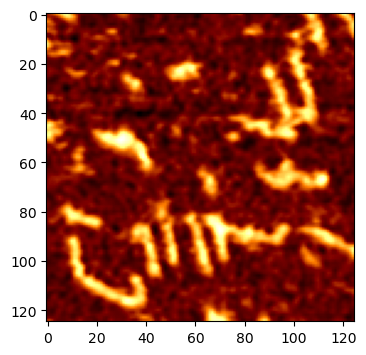

In [187]:
# Set BASE_DIR containing a file and config.yaml
BASE_DIR=Path(os.getcwd())
FILE_EXT = ".gwy"
##############################
#IMG_KEY = "PO-Wavemode500"
IMG_KEY = "PO-Wavemode125"
CONFIG = "config_PO.yaml"
##############################
#IMG_KEY = "PL-Wavemode500"
#CONFIG = "config_PL.yaml"
##############################
IMG_FILES = [BASE_DIR.joinpath('data').joinpath(IMG_KEY+".gwy"),]

config = read_yaml(BASE_DIR.joinpath('data').joinpath(CONFIG))
loading_config = config["loading"]
filter_config = config["filter"]
filter_config.pop("run")
grain_config = config["grains"]
grain_config.pop("run")
loaded_data = LoadScans(IMG_FILES, **config["loading"])
loaded_data.get_data()

# Plot the loaded scan in its raw format
aspect = loading_config["scale"]["xy_aspect"]
SpmPlot.image(loaded_data.image, cmap="afmhot", aspect=aspect)

In [188]:
# Filter
filtered_image = Filters(
        image=loaded_data.img_dict[IMG_KEY]["image_original"],
        filename=loaded_data.img_dict[IMG_KEY]["img_path"],
        pixel_to_nm_scaling=loaded_data.img_dict[IMG_KEY]["pixel_to_nm_scaling"],
        **filter_config,)
filtered_image.filter_image()

Available NumPy arrays to plot in filter_image.images dictionary :

dict_keys(['pixels', 'initial_median_flatten', 'initial_tilt_removal', 'initial_quadratic_removal', 'initial_scar_removal', 'masked_median_flatten', 'masked_tilt_removal', 'masked_quadratic_removal', 'secondary_scar_removal', 'scar_mask', 'mask', 'zero_average_background', 'gaussian_filtered', 'initial_nonlinear_polynomial_removal', 'masked_nonlinear_polynomial_removal'])


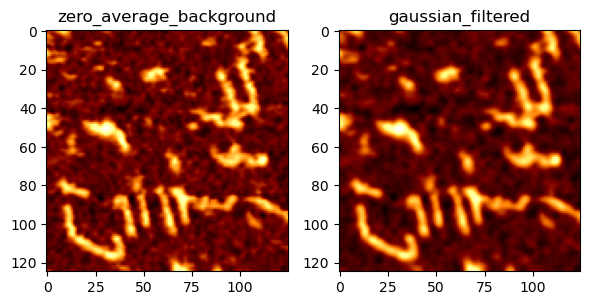

In [189]:
print(f"Available NumPy arrays to plot in filter_image.images dictionary :\n\n{filtered_image.images.keys()}")
SHOW_TILE = True
if SHOW_TILE:
    keys = ['zero_average_background','gaussian_filtered']
    SpmPlot.tile_images(filtered_image.images, image_keys=keys, cmap="afmhot")

# Find grains

Here polymer chains are detected by using Grains of Topostats. Resulting Numpy array of "labelled_regions_02" conatins index label starting from 1 for all polymer chains. 

In [190]:
grains = Grains(
                image=filtered_image.images["zero_average_background"],
                filename=filtered_image.filename,
                pixel_to_nm_scaling=filtered_image.pixel_to_nm_scaling,
                **grain_config,
                )
grains.find_grains()

method = grain_config["threshold_method"]
threshold = grain_config["threshold_std_dev"]["above"]
print(f"Method: {method}, threshold: {threshold}")
print(f"Resulting image keys above threshold:\n {grains.directions['above'].keys()}")

lbl1 = grains.directions['above']['labelled_regions_01']
lbl2 = grains.directions['above']['labelled_regions_02']
(lbl1_count,lbl2_count) = (lbl1.max(), lbl2.max())
lbl_grains = {
    f'lbl1 ({lbl1_count})':lbl1, 
    f'lbl2 ({lbl2_count})':lbl2,
}
SHOW_LABELLED = False
if SHOW_LABELLED:
    tile_images(lbl_grains, cmap='afmhot')

Method: std_dev, threshold: 1.0
Resulting image keys above threshold:
 dict_keys(['mask_grains', 'labelled_regions_01', 'tidied_border', 'removed_noise', 'removed_small_objects', 'labelled_regions_02', 'coloured_regions'])


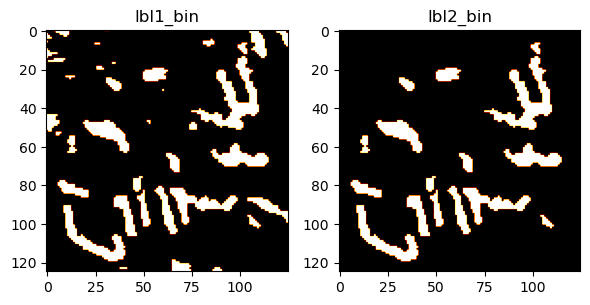

In [191]:
lbl1_bin = lbl1.astype(dtype=bool).astype(dtype=np.int32)
lbl2_bin = lbl2.astype(dtype=bool).astype(dtype=np.int32)
bin_grains = {"lbl1_bin":lbl1_bin, "lbl2_bin":lbl2_bin}
SpmPlot.tile_images(bin_grains, cmap="afmhot")

# Line detection

Linemol module is for detection of linear part of polymer chain of SPM height data. Principle of this analysis is to score all possible lines in a molecule. The score is calculated from the sum of the height values of the pixels that make up the line.

This module has three classes to handle data processing.
- **`Line`** - contains pixel positions of a line
- **`Molecule`** - contains a molecule from preceding grain analysis
- **`LineDetection`** - tools to analyse linear part of molecules to generate results as Pandas.DataFrame

## Data import and filtering by Topostats
Topostats is a Python library for topological data analysis. It provides a set of tools for analyzing and visualizing topological data, such as persistent homology, persistent diagrams, and other related techniques. It is designed to be easy to use and extend, and is suitable for both research and educational purposes. Filtering and finding grains from a Gwyddion file are conducted by Topostats software program. 

## Molecule class
Pixels of each molecule are obtained from grains.directions["above"]["labelled_regions_02"]. A class of `LineDetection` handles the labelled regions ndarray. All molecules are stored as `Molecule` object that provide positions, vectors generated from the positions, methods for detection of linear part.

In [420]:
import linemol
importlib.reload(linemol)
from linemol import Molecule, LineDetection, Line, SpmPlot

In [421]:
source = filtered_image.images["gaussian_filtered"]
config = {"min_len":7, "max_len":20,"allowed_empty":1, "use_cache":True}

ld = LineDetection(lbl2, source, **config)

## Processing
Number of all possible vectors in a molecule sometimes comes enormous, so several steps are implemented to reduce unnecessary lines.

### Filtering and scoring
vector pairs are filtered by direction and length. The minimum and maximum length are defined as `min_len` and `max_len` in a config dict.
-  Exclude vectors from the set that are facing the third and fourth quadrants.
-  Exclude vectors exceeding provided minimum and maximum length

After collecting the set of vectors, a synthetic straight line is drawn in 2D binary array. When original binary data has gaps along the synthetic line, it is considered to have 'empty' pixels. A line with large number of empty pixels are excluded because it should not be regard as a straight and continuous line. The maximum pixel number is defined as `allowed_empty` in a config dict.

Score for each lines are accumulated Z-height at all pixels from source image. Resulting statistics lines are stored as pd.DataFrame.
 - score_df : all results of filtered and scored lines
 - stat_df  : statistics for each molecules

In [422]:
count = 0
time0 = time.perf_counter()
for i in tqdm(range(len(ld.molecules))):
    mol = ld.molecules[i]
    filtered = ld.filter_by_length(mol)
    if filtered is not None:
        lines_cnt = ld.score_lines(mol, filtered)
        if lines_cnt > 0:
            count += 1
time1 = time.perf_counter()
duration = time1 - time0
print(f"{count} molecules calculated in {duration:.3f}")
total_row = len(ld.score_df)
print(f'Total {total_row} rows recorded in score_df.')

  0%|          | 0/16 [00:00<?, ?it/s]

15 molecules calculated in 7.893
Total 9854 rows recorded in score_df.


### Eliminating overlapping lines
Some lines are covered by a longer line, others are covered partially. Shorter lines covered with other line are flagged at overlapped column in score_df.

In [423]:
# Preparing columns
ld.prep_overlap_elim()

mol_indecies = score_df["mol_idx"].to_numpy()
for m in tqdm(range(len(mol_indecies))):
    midx = mol_indecies[m]
    ld.eliminate_overlap(midx, diff_pix=2)

  0%|          | 0/9854 [00:00<?, ?it/s]

In [424]:
# Save as pickle
SAVE_FILE = True
LOAD_FILE = False
prefix = f'{IMG_KEY}_{config["min_len"]}_{config["max_len"]}_{config["allowed_empty"]}_'

if SAVE_FILE:
    ld.score_df.to_pickle(prefix + "score_df.pkl.gz")
    ld.stat_df.to_pickle(prefix + "stat_df.pkl.gz")

if LOAD_FILE:
    score_df = pd.read_pickle(prefix + "score_df.pkl.gz")

In [425]:
# Filtering statistics is in stat_df
ld.stat_df.sort_values("pixels", ascending=False).head()

,mol_idx,pixels,total_vecs,len_filtered,total_lines,min_len,max_len,max_pix,score_cutoff,overlap_checked
0,2,415,85905,47690,NaN,7,20,500,NaN,True
13,15,248,30628,13706,NaN,7,20,500,NaN,True
10,12,222,24531,13078,NaN,7,20,500,NaN,True
5,7,189,17766,9979,NaN,7,20,500,NaN,True
3,5,178,15753,8689,NaN,7,20,500,NaN,True


In [436]:
ld.score_df.head()

,mol_idx,score,empty,line_idx,x1,y1,x2,y2,length,angle,norm_score,overlapped,overlap_by
0,2,6.169212,0,5934,19,16,24,35,19.646883,75.256437,3.041264,False,
1,2,6.147439,0,6523,20,17,23,36,19.235384,81.027373,3.019148,False,
2,2,6.136610,0,6451,19,17,24,36,19.646883,75.256437,3.008148,False,
3,2,6.127677,0,5933,19,16,23,35,19.416488,78.111342,2.999074,False,
4,2,6.110148,0,6004,20,16,23,35,19.235384,81.027373,2.981269,False,


# Results
An image overlaid with lines at the highest score.

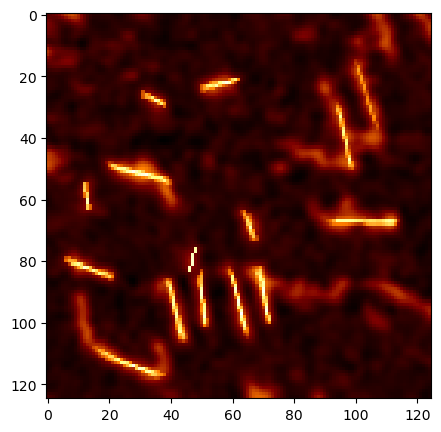

In [432]:
# Overlay
overlaid = ld.overlay_lines(num_lines=10, factor=20)
SpmPlot.image(overlaid, cmap="afmhot", figsize=(5,5))

# Checking individual molecule

A molecule in LineDetection instance can be accessed by its index

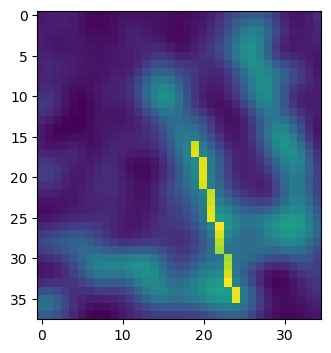

In [461]:
# Getting a molecule
mol_idx = 2
mol = ld.molecules[mol_idx - 1]
src_z_max = mol.src_img.max()

# Getting aline from score_df DataFrame
line_idx = 5934
row = score_df.loc[(score_df["mol_idx"]==mol_idx) & (score_df["line_idx"]==line_idx)]
line = Line.create_from_pos(row.x1[0], row.y1[0], row.x2[0], row.y2[0])

# Emphasize line by multiplying line mask with maximum height of this molecule
line_img = line.get_mask(mol.height,mol.width)
SpmPlot.image(mol.src_img + line_img * src_z_max)

<Axes: xlabel='angle', ylabel='norm_score'>

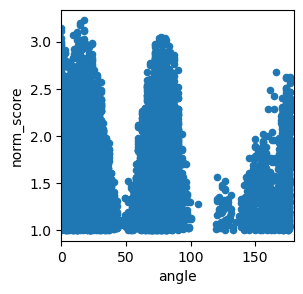

In [465]:
# Plotting angle of all lines
ld.score_df.plot.scatter(x="angle",y="norm_score",xlim=(0,180), figsize=(3,3))

<Axes: xlabel='angle', ylabel='norm_score'>

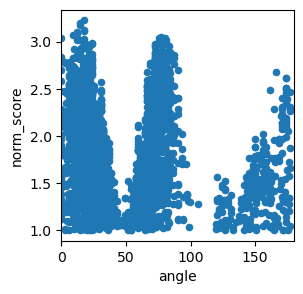

In [466]:
# Plotting lines that are not covered by other lines
ld.score_df.loc[ld.score_df["overlapped"]==False].plot.scatter(x="angle",y="norm_score", xlim=(0,180), figsize=(3,3))

<Axes: ylabel='Frequency'>

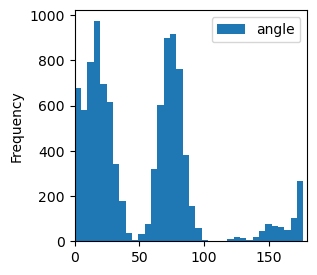

In [467]:
ld.score_df.plot.hist(y="angle",bins=36,xlim=(0,180),figsize=(3,3))

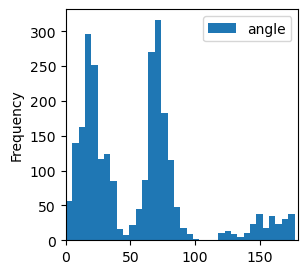

In [470]:
result = ld.score_df[ld.score_df["overlapped"]==False].plot.hist(y="angle",bins=36,xlim=(0,180), figsize=(3,3))

In [484]:
angles = ld.score_df[ld.score_df["overlapped"]==False]["angle"]
angle_dist = np.histogram(angles, range=(0,180), bins=36)
len(angle_dist[1])

37

In [479]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

def func(x, *params):

    #paramsの長さでフィッティングする関数の数を判別。
    num_func = int(len(params)/3)

    #ガウス関数にそれぞれのパラメータを挿入してy_listに追加。
    y_list = []
    for i in range(num_func):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
        y_list.append(y)

    #y_listに入っているすべてのガウス関数を重ね合わせる。
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i

    #最後にバックグラウンドを追加。
    y_sum = y_sum + params[-1]

    return y_sum

def fit_plot(x, *params):
    num_func = int(len(params)/3)
    y_list = []
    for i in range(num_func):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])]
        y = y + amp * np.exp( -((x - ctr)/wid)**2) + params[-1]
        y_list.append(y)
    return y_list

In [485]:
#初期値のリストを作成
#[amp,ctr,wid]
guess = []
guess.append([250, 15, 5])
guess.append([250, 75, 5])

#バックグラウンドの初期値
background = 5

#初期値リストの結合
guess_total = []
for i in guess:
    guess_total.extend(i)
guess_total.append(background)

###############################
x = angle_dist[1][:-1]
y = angle_dist[0]
popt, pcov = curve_fit(func, x, y, p0=guess_total)
###########################

In [486]:
popt,pcov

(array([243.95634436,  16.71046873,  12.88025106, 300.74709611,
         69.51700891,   8.59185076,  17.09199519]),
 array([[ 2.91573359e+02,  2.31912076e-01, -8.64529073e+00,
          1.52609543e+01, -2.38952943e-03,  8.87118718e-01,
         -2.17518313e+01],
        [ 2.31912076e-01,  5.09625786e-01, -1.73202081e-02,
          5.71349952e-02,  5.39930114e-05,  2.88972660e-03,
         -7.65276616e-02],
        [-8.64529073e+00, -1.73202081e-02,  1.19213883e+00,
          1.29352944e+00,  3.73888083e-04,  7.14476583e-02,
         -1.80149517e+00],
        [ 1.52609543e+01,  5.71349952e-02,  1.29352944e+00,
          4.19082643e+02,  1.44276274e-04, -6.92334554e+00,
         -1.96448924e+01],
        [-2.38952943e-03,  5.39930114e-05,  3.73888083e-04,
          1.44276274e-04,  2.20490584e-01,  4.31986410e-05,
         -6.52945425e-04],
        [ 8.87118718e-01,  2.88972660e-03,  7.14476583e-02,
         -6.92334554e+00,  4.31986410e-05,  4.85911526e-01,
         -1.11783721e+00],
  

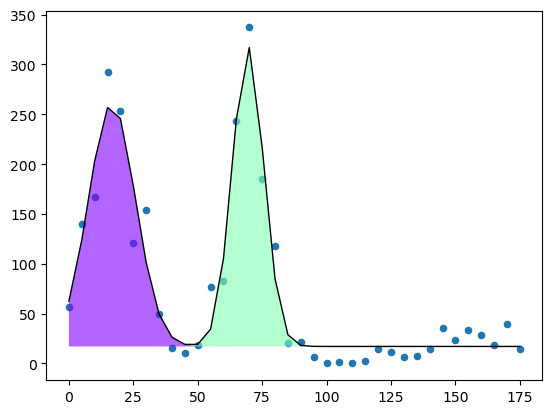

In [487]:
fit = func(x, *popt)
plt.scatter(x, y, s=20)
plt.plot(x, fit , ls='-', c='black', lw=1)

y_list = fit_plot(x, *popt)
baseline = np.zeros_like(x) + popt[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.6)